# Entrega Final

In [2]:
import os
import pandas as pd
import numpy as np
import unicodedata
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
!wget https://raw.githubusercontent.com/ronaldrodas/ai4eng-20242/main/kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

--2024-12-02 00:26:33--  https://raw.githubusercontent.com/ronaldrodas/ai4eng-20242/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67 [text/plain]
Saving to: ‘kaggle.json.1’

kaggle.json.1       100%[===================>]      67  --.-KB/s    in 0s      

2024-12-02 00:26:33 (3.04 MB/s) - ‘kaggle.json.1’ saved [67/67]

 84% 17.0M/20.1M [00:00<00:00, 47.5MB/s]
100% 20.1M/20.1M [00:00<00:00, 47.4MB/s]


#Unzip and inspect data

In [4]:
!unzip udea*.zip > /dev/null

#Cargar datos de entrenamiento con panda

In [5]:
# Cargar datos
df = pd.read_csv("train.csv")
print(f"Shape of loaded dataframe: {df.shape}")
df.info()
df.head()

Shape of loaded dataframe: (692500, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   ID                              692500 non-null  int64 
 1   PERIODO                         692500 non-null  int64 
 2   ESTU_PRGM_ACADEMICO             692500 non-null  object
 3   ESTU_PRGM_DEPARTAMENTO          692500 non-null  object
 4   ESTU_VALORMATRICULAUNIVERSIDAD  686213 non-null  object
 5   ESTU_HORASSEMANATRABAJA         661643 non-null  object
 6   FAMI_ESTRATOVIVIENDA            660363 non-null  object
 7   FAMI_TIENEINTERNET              665871 non-null  object
 8   FAMI_EDUCACIONPADRE             669322 non-null  object
 9   FAMI_EDUCACIONMADRE             668836 non-null  object
 10  ESTU_PAGOMATRICULAPROPIO        686002 non-null  object
 11  RENDIMIENTO_GLOBAL              692500 non-null  ob

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


La gráfica facilita una comparación visual rápida de cómo las categorías de RENDIMIENTO_GLOBAL se distribuyen en las diferentes columnas. Esto puede ser útil para identificar columnas que tengan un mayor impacto en el rendimiento o para seleccionar variables clave en un análisis posterior, como un modelo predictivo.

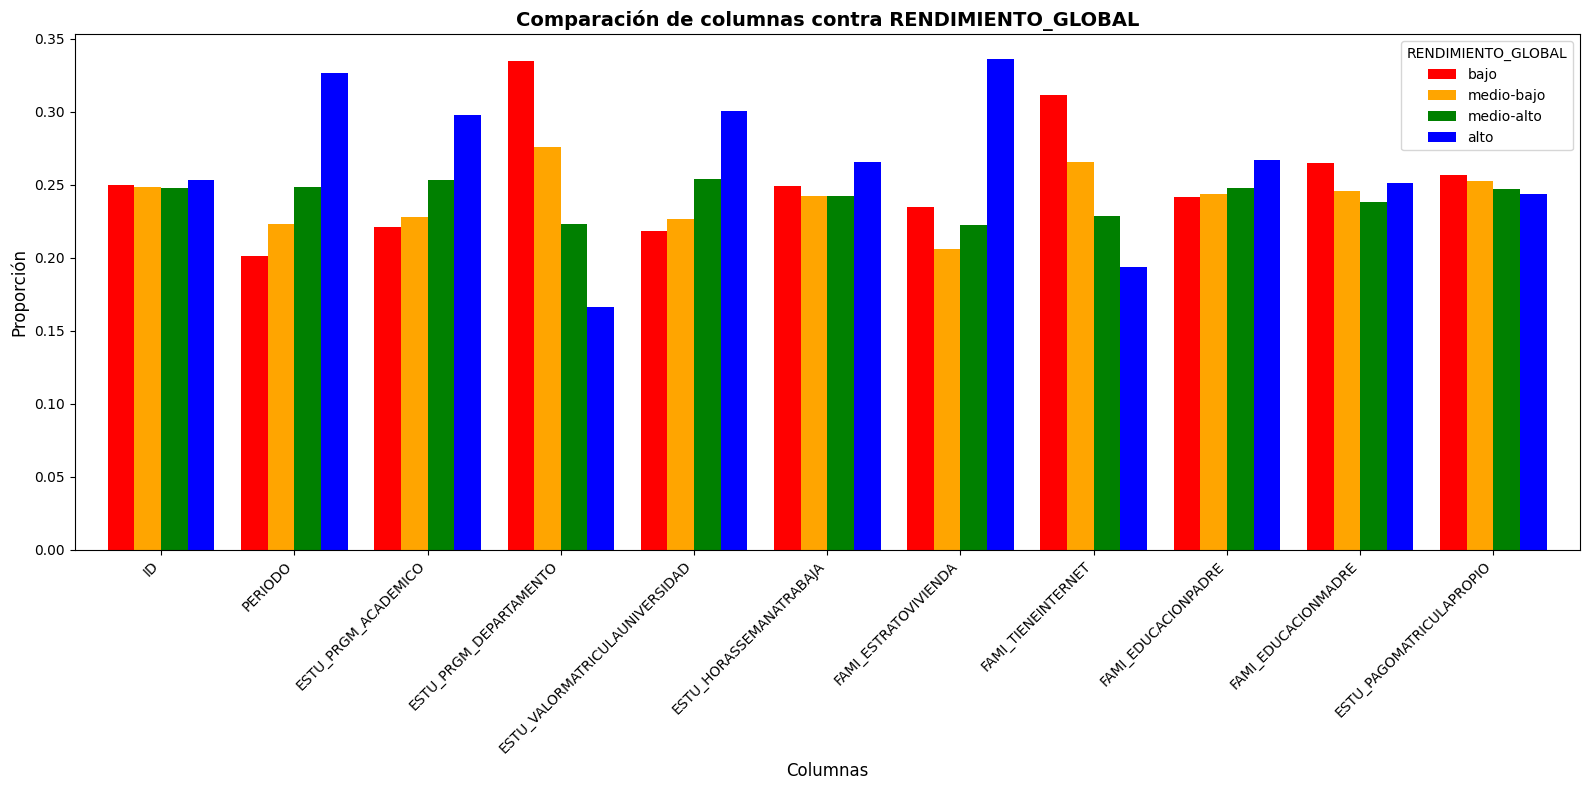

In [14]:
import matplotlib.pyplot as plt

# Lista de columnas, excluyendo 'RENDIMIENTO_GLOBAL'
columns = [col for col in df.columns if col != 'RENDIMIENTO_GLOBAL']

# Crear un DataFrame para almacenar las frecuencias
resultados = pd.DataFrame()

# Calcular las proporciones por columna
categories = ['bajo', 'medio-bajo', 'medio-alto', 'alto']
for column in columns:
    # Calcular la frecuencia relativa por categoría
    frecuencias = df.groupby(column)['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).unstack(fill_value=0)
    frecuencias = frecuencias.reindex(columns=categories, fill_value=0)  # Asegurar orden de categorías
    frecuencias = frecuencias.sum(axis=0) / frecuencias.sum().sum()  # Proporción total
    resultados[column] = frecuencias

# Transponer para que las columnas sean las categorías
resultados = resultados.T

# Crear el gráfico de barras agrupadas
ax = resultados.plot(kind='bar', figsize=(16, 8), width=0.8, color=['red', 'orange', 'green', 'blue'])

# Configurar etiquetas y título
plt.title("Comparación de columnas contra RENDIMIENTO_GLOBAL", fontsize=14, fontweight='bold')
plt.ylabel("Proporción", fontsize=12)
plt.xlabel("Columnas", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="RENDIMIENTO_GLOBAL", loc='upper right')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

El código normaliza las categorías académicas (eliminando tildes y pasando a minúsculas), las compara con un diccionario de áreas de conocimiento y asigna a cada categoría el área correspondiente. Si no hay coincidencia, asigna "OTRO". Luego, aplica este mapeo a la columna ESTU_PRGM_ACADEMICO del DataFrame.

In [ ]:
# Función para normalizar texto (eliminar tildes y pasar a minúsculas)
def eliminar_tildes(palabra):
    return ''.join(c for c in unicodedata.normalize('NFD', palabra) if unicodedata.category(c) != 'Mn').lower()

# Diccionario de mapeo de áreas de conocimiento
knowledge_areas = {
    "GESTION Y ADMINISTRACION": ["ADMINISTRACION", "BANCA", "DIRECCION", "GESTION", "ARCHIVISTA", "BIBLIOTECOLOGIA", "GERENCIA"],
    "EDUCACION Y FORMACION": ["PEDAGOGIA", "ACTIVIDAD", "DEPORTE", "ENTRENAMIENTO", "RECREACION", "MAESTRO", "LICENCIATURA"],
    "INGENIERIA Y TECNOLOGIAS": ["INGENIERIA", "CONTADURIA", "INVESTIGACION", "SISTEMAS", "URBANISMO", "MATEMATICAS",
                                "BIOINGENIERIA", "BIOTECNOLOGIA", "COMPUTACION", "INFORMACION", "CONSTRUCCION", "ESTADISTICA"],
    "CIENCIAS DE LA SALUD": ["MEDICINA", "NUTRICION", "ODONTOLOGIA", "OPTOMETRIA", "SALUD", "TERAPIA", "ENFERMERIA",
                            "FARMACIA", "FISIOTERAPIA", "FONOAUDIOLOGIA", "GERONTOLOGIA", "QUIRURGICA"],
    "CIENCIAS SOCIALES Y POLITICAS": ["CRIMINALISTICA", "POLITICA", "DERECHO", "DESARROLLO", "GOBIERNO", "JURISPRUDENCIA", "SOCIOLOGIA"],
    "NEGOCIOS Y ECONOMIA": ["MERCADOLOGIA", "NEGOCIOS", "FINANZAS", "MARKETING", "PUBLICIDAD", "COMERCIO", "ECONOMIA", "LOGISTICA"],
    "ALIMENTACION Y AGRICULTURA": ["AGROINDUSTRIAL", "AGRONOMIA", "GASTRONOMIA", "TURISMO", "HOTELERIA"],
    "CIENCIAS HUMANAS Y SOCIALES": ["PERIODISMO", "COMUNICACION", "FILOSOFIA", "PSICOLOGIA", "SOCIOLOGIA", "TEOLOGIA",
                                    "ANTROPOLOGIA", "HISTORIA", "ARQUEOLOGIA"],
    "CIENCIAS AMBIENTALES Y NATURALES": ["MICROBIOLOGIA", "QUIMICA", "BIOLOGIA", "AMBIENTALES", "ECOLOGIA", "FISICA",
                                         "GEOGRAFIA", "GEOLOGIA"],
    "ARTES Y HUMANIDADES": ["MUSICA", "ARTES", "CINE", "DISEÑO", "ANIMACION", "TEATRO", "TRADUCCION", "LITERATURA",
                            "DANZA", "FOTOGRAFIA", "LINGUISTICA"]
}

# Función para mapear áreas de conocimiento
def mapear_area(categoria):
    categoria = eliminar_tildes(categoria)
    for area, keywords in knowledge_areas.items():
        if any(eliminar_tildes(keyword) in categoria for keyword in keywords):
            return area
    return "OTRO"

# Mapear áreas en 'ESTU_PRGM_ACADEMICO'
df["ESTU_PRGM_ACADEMICO"] = df["ESTU_PRGM_ACADEMICO"].apply(mapear_area)


El código df.ESTU_PRGM_ACADEMICO.value_counts() cuenta la frecuencia de cada valor único en la columna ESTU_PRGM_ACADEMICO del DataFrame

In [ ]:
df.ESTU_PRGM_ACADEMICO.value_counts()

,count
ESTU_PRGM_ACADEMICO,
INGENIERIA Y TECNOLOGIAS,203883
GESTION Y ADMINISTRACION,131914
CIENCIAS HUMANAS Y SOCIALES,71400
EDUCACION Y FORMACION,70035
CIENCIAS SOCIALES Y POLITICAS,59996
CIENCIAS DE LA SALUD,59113
OTRO,39162
NEGOCIOS Y ECONOMIA,30546
ARTES Y HUMANIDADES,15124



Este código mapea los valores de la columna RENDIMIENTO_GLOBAL del DataFrame df a valores numéricos según el diccionario target_map

In [ ]:
# Codificar la variable objetivo
target_map = { "bajo": 0, "medio-bajo": 1, "medio-alto": 2, "alto": 3}
df["RENDIMIENTO_GLOBAL"] = df["RENDIMIENTO_GLOBAL"].map(target_map)

Este código realiza la codificación One-Hot Encoding para las columnas categóricas del DataFrame df

In [ ]:
# Codificar columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

Este código combina las características codificadas con el DataFrame original df:

Eliminar las columnas categóricas originales: df.drop(columns=categorical_columns) elimina las columnas que fueron codificadas (las que tienen tipo de datos object), para evitar duplicación de información.

Concatenar las características codificadas: pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1) concatena el DataFrame original (sin las columnas categóricas) con el DataFrame encoded_df que contiene las nuevas columnas codificadas. El parámetro axis=1 asegura que la concatenación se haga por columnas, no por filas.

El resultado es un DataFrame df donde las columnas categóricas originales han sido reemplazadas por las nuevas columnas codificadas One-Hot.

In [ ]:
# Combinar características codificadas con el DataFrame original
df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

Este código divide el DataFrame df en características (X) y variable objetivo (y). Luego, utiliza train_test_split para dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%) de forma reproducible, asignando los resultados a X_train, X_test, y_train y y_test.

In [ ]:
# División del conjunto de datos
X = df.drop(columns=["RENDIMIENTO_GLOBAL"])
y = df["RENDIMIENTO_GLOBAL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


:Este código entrena un modelo LogisticRegression con los datos de entrenamiento X_train y y_train, y lo guarda en la variable modelo_final.

In [ ]:
# Entrenar el modelo
print("Entrenando el modelo LogisticRegression...")
modelo_final = LogisticRegression(max_iter=3000)
modelo_final.fit(X_train, y_train)

Entrenando el modelo LogisticRegression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=3000)

In [ ]:
# Evaluación en el conjunto de prueba
print("Evaluando el modelo en el conjunto de prueba...")
y_pred = modelo_final.predict(X_test)
# Calcular precisión (accuracy)
from sklearn.metrics import accuracy_score
precision = accuracy_score(y_test, y_pred)
print(f"Precisión en el conjunto de prueba: {precision:.4f}\n")

Evaluando el modelo en el conjunto de prueba...
Precisión en el conjunto de prueba: 0.3991



Este código carga el archivo test.csv en un DataFrame llamado test y aplica la función mapear_area a la columna ESTU_PRGM_ACADEMICO para asignar a cada categoría su correspondiente área de conocimiento.

In [ ]:
# Preprocesar el conjunto de prueba
test = pd.read_csv("test.csv")
test["ESTU_PRGM_ACADEMICO"] = test["ESTU_PRGM_ACADEMICO"].apply(mapear_area)


Este código codifica las columnas categóricas del conjunto de prueba utilizando el codificador ajustado previamente y crea un DataFrame con las características codificadas.

In [ ]:
# Codificar columnas categóricas del conjunto de prueba
encoded_test_features = encoder.transform(test[categorical_columns])
encoded_test_df = pd.DataFrame(encoded_test_features, columns=encoder.get_feature_names_out(categorical_columns))


Este código agrega las columnas faltantes al conjunto de prueba y las organiza para que coincidan con las columnas del conjunto de entrenamiento.


In [ ]:
# Asegurar que las columnas coincidan entre entrenamiento y prueba
missing_cols = set(X.columns) - set(encoded_test_df.columns)
for col in missing_cols:
    encoded_test_df[col] = 0
encoded_test_df = encoded_test_df[X.columns]

Este código predice la variable objetivo para el conjunto de prueba y convierte las predicciones numéricas a sus categorías originales en texto.

In [ ]:
# Predicción y sumisión
X_test_data = encoded_test_df.values
predicciones = modelo_final.predict(X_test_data)
reverse_map = {v: k for k, v in target_map.items()}
predicciones_texto = [reverse_map[p] for p in predicciones]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Este código crea un archivo CSV con las predicciones y el ID del conjunto de prueba, y lo guarda como submission_logistic_regression.csv

In [ ]:
# Crear archivo de sumisión
submission = pd.DataFrame({
    "ID": test["ID"],
    "RENDIMIENTO_GLOBAL": predicciones_texto
})
submission.to_csv("submission_logistic_regression.csv", index=False)
print("Archivo de sumisión creado: submission_logistic_regression.csv\n")

Archivo de sumisión creado: submission_logistic_regression.csv



!head submission_logistic_regression.csv muestra las primeras filas del archivo y submission.shape muestra las dimensiones del DataFrame de sumisión.

In [ ]:
!head submission_logistic_regression.csv
submission.shape

ID,RENDIMIENTO_GLOBAL
550236,alto
98545,medio-bajo
499179,alto
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,medio-bajo


(296786, 2)

Este comando envía el archivo submission_gradient_boosting.csv a la competencia de Kaggle con el mensaje de la solución.

In [ ]:
!kaggle competitions submit -c udea-ai4eng-20242 -f submission_logistic_regression.csv -m "Ronald Rodas Goez solución con logistic_regression"

100% 3.90M/3.90M [00:00<00:00, 17.7MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia